In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker

from load_data.db_model.activity import Activity
from load_data.db_model.sensor_data import SensorData
from load_data.db_model.session import Session
from load_data.db_model.subject import Subject

load_dotenv()
DATABASE_URI = os.getenv("DATABASE_URI")
db_engine = create_engine(DATABASE_URI)
SessionLocal = sessionmaker(bind=db_engine)
db = SessionLocal()

In [5]:
sensor_data_count = (
    db.query(Subject.id, func.count("*"))
    .join(Session)
    .join(SensorData)
    .group_by(Subject.id)
    .order_by(Subject.id)
    .all()
)

df = pd.DataFrame(sensor_data_count, columns=["Subject_ID", "SensorData_Count"])
total_count = df["SensorData_Count"].sum()
total_df = pd.DataFrame([{"Subject_ID": "Total", "SensorData_Count": total_count}])
df = pd.concat([df, total_df])

db.close()
print(df.to_string(index=False))

Subject_ID  SensorData_Count
         1             35174
         2             35532
         3             35380
         4             35328
         5             33947
         6             32205
         7             34253
         8             33332
         9             34354
        10             33690
     Total            343195


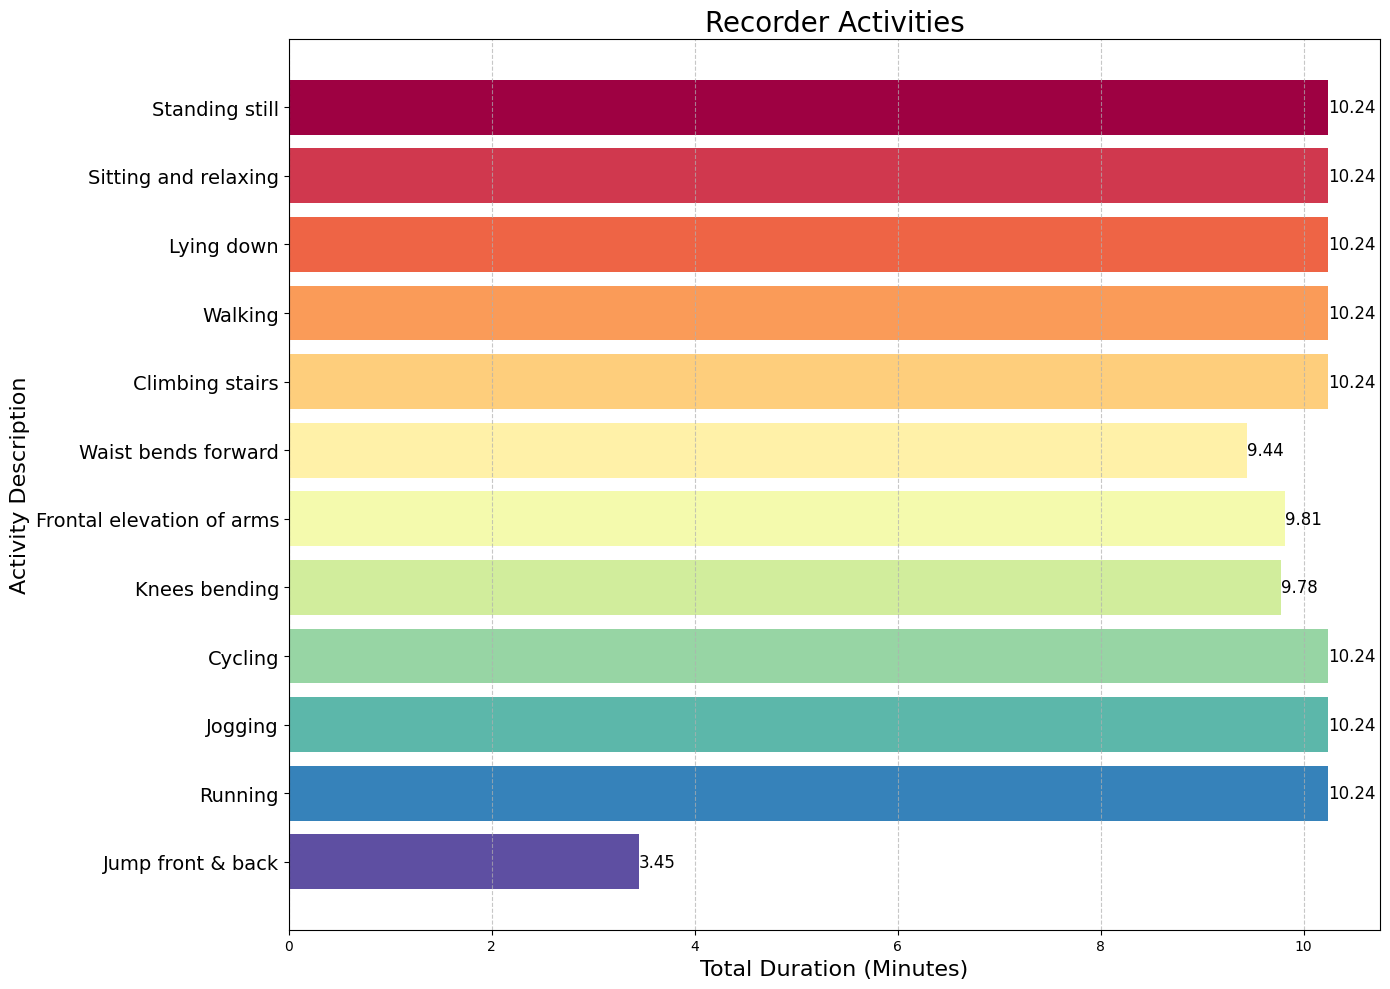

In [6]:
activity_sensor_data_count = (
    db.query(Activity.description, func.count(SensorData.sequence))
    .join(Session, Session.id == SensorData.session_id)
    .join(Activity, Activity.id == Session.activity_id)
    .group_by(Activity.description, Activity.id)
    .order_by(Activity.id)
    .all()
)
df_activity_sensor_data = pd.DataFrame(
    activity_sensor_data_count, columns=["Activity Description", "Sensor Data Count"]
)

df_activity_sensor_data["Duration (Minutes)"] = (
    df_activity_sensor_data["Sensor Data Count"] / 50 / 60
)

plt.figure(figsize=(14, 10))

colors = plt.cm.Spectral(np.linspace(0, 1, len(df_activity_sensor_data)))

plt.barh(
    df_activity_sensor_data["Activity Description"],
    df_activity_sensor_data["Duration (Minutes)"],
    color=colors,
)

plt.title("Recorder Activities", fontsize=20)
plt.xlabel("Total Duration (Minutes)", fontsize=16)
plt.ylabel("Activity Description", fontsize=16)

plt.yticks(fontsize=14)

for index, value in enumerate(df_activity_sensor_data["Duration (Minutes)"]):
    plt.text(value, index, f"{value:.2f}", va="center", fontsize=12)

plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

db.close()